In [4]:
import casadi
from casadi import *
import numpy

In [128]:



    # Initialize constants
    b = 0.22  # Distance between wheels
    v_max = 1  # Maximum speed (m/s)
    a_max = 3  # Maximum acceleration (m/s^2)
    omega_max = 1  # Maximum angular velocity (rad/s)
    alpha_max = 3  # Maximum angular acceleration (rad/s^2)
    T_s = 0.5  # Sampling time
    horizon = 5  # Prediction horizon
    ref = vertcat(10, 10, 0)  # Target reference position
    Q = diag(DM([10, 10, 0]))  # State weights
    R = diag(DM([8, 1]))  # Control input weights
    
    # CasADi optimizer
    opti = Opti()
    
    # Optimization variables
    nx = 3  # Number of states
    nu = 2  # Number of inputs
    x = opti.variable(nx, horizon + 1)  # States
    
    u = opti.variable(nu, horizon)  # Control inputs
    
    vr = opti.variable(1, horizon)  # Right wheel velocity
    vl = opti.variable(1, horizon)  # Left wheel velocity
    
    a = opti.variable(1, horizon)  # Linear acceleration
    alpha = opti.variable(1, horizon)  # Angular acceleration
    
    # Parameters
    x0 = opti.parameter(nx,1)  # Initial state
    u_prev = opti.parameter(nu,1)  # Previous control input

    # Define state and control model
    f = lambda x,u: vertcat(u[0]*cos(x[2]), u[0]*sin(x[2]), u[1]) # dx/dt = f(x,u)

    # Define objective function
    objective = 0
    for k in range(horizon): 
        
       # Tracking error cost
       objective += mtimes([(x[:, k + 1] - ref).T, Q, (x[:, k + 1] - ref)]) + mtimes([u[:, k].T, R, u[:, k]])

        
       # Runge-Kutta 4 integration
       k1 = f(x[:,k],          u[:,k])
       k2 = f(x[:,k]+T_s/2*k1, u[:,k])
       k3 = f(x[:,k]+T_s/2*k2, u[:,k])
       k4 = f(x[:,k]+T_s*k3,   u[:,k])
       x_next = x[:,k] + T_s/6*(k1+2*k2+2*k3+k4) 
       opti.subject_to(x[:,k+1]==x_next) 
        
    # Minimize the objective
    opti.minimize(objective)

    # Control input constraints
    opti.subject_to(opti.bounded(-v_max, u[0,:], v_max)) # linear speed is limited
    opti.subject_to(opti.bounded(-omega_max, u[1,:], omega_max)) # linear speed is limited


    opti.subject_to(x[:,0]==x0)  


     # Linear acceleration constraint
    a = (u[0,:] - u_prev[0]) / T_s
    opti.subject_to(opti.bounded(-a_max, a, a_max))
    
    # Angular acceleration constraint
    alpha = (u[1, :] - u_prev[1]) / T_s
    opti.subject_to(opti.bounded(-alpha_max , alpha, alpha_max ))

    # Enforce relationships between u, vr, and vl
    opti.subject_to(u[0,:] == 0.5*(vl + vr))
    opti.subject_to(u[1,:] == (vr - vl)/b)


    # ---- make the solver silent ------ to see the time of computation, iterations... remove or change to True
    opts = {}
    another_opts = {}
    opts['verbose'] = False
    opts['print_time'] = False
    another_opts['print_level'] = 0

    # ---- solve NLP  ------
    opti.opts = {"ipopt.tol":1e-10, "expand":True}
    opti.solver("ipopt", opts,another_opts) # set numerical backend


    controller = opti.to_function("controller", [u_prev, x0], [u[:,0]], ["u_prev", "x0"], ["u_opt"]) #para defenir o estado inicial tem-se de enviar por meio de parametros a não ser que fosse todo o X, o U como é output não dá erro



  

    

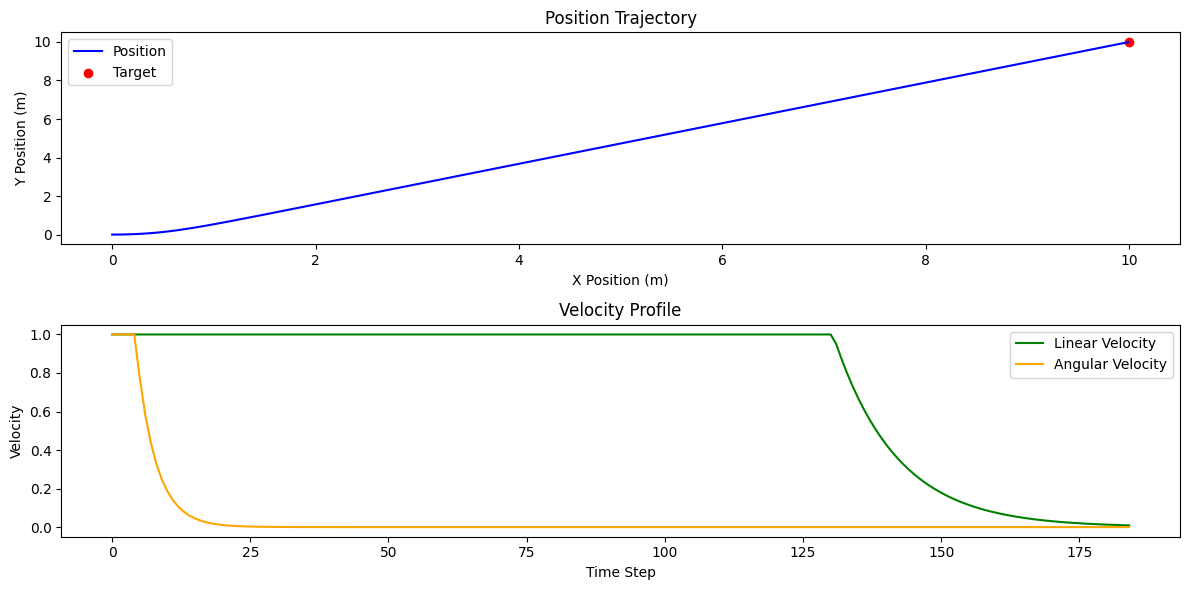

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from casadi import *

# Simulation parameters
T_sim = 60  # Total simulation time (s)
T_s = 0.1   # Sampling time (s)
N_steps = int(T_sim / T_s)  # Number of simulation steps


# Dynamics function (robot model)
def f(x, u):
    x_dot = vertcat(
        u[0] * cos(x[2]),  # dx/dt
        u[0] * sin(x[2]),  # dy/dt
        u[1]              # dtheta/dt
    )
    return x_dot

# Initial state and reference
x_current = DM([0, 0, 0])  # Initial state [x, y, theta]
ref_sim = DM([10, 10])  # Target position [x, y]
u_prev = DM([0, 0])  # Initial control input [linear_velocity, angular_velocity]

# Data logging
x_history = np.zeros((3, N_steps + 1))
x_history[:, 0] = np.array(x_current).flatten()
linear_velocities = []
angular_velocities = []

# Simulation loop
for t in range(N_steps):
    # Call the controller
    u_opt = controller(u_prev, x_current)

    # Log control inputs
    linear_velocities.append(u_opt[0].full().item())
    angular_velocities.append(u_opt[1].full().item())

    # Update state using dynamics (Runge-Kutta 4 integration)
    k1 = f(x_current, u_opt)
    k2 = f(x_current + T_s / 2 * k1, u_opt)
    k3 = f(x_current + T_s / 2 * k2, u_opt)
    k4 = f(x_current + T_s * k3, u_opt)
    x_current = x_current + T_s / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    # Log state
    x_history[:, t + 1] = np.array(x_current).flatten()

    # Update previous control input
    u_prev = u_opt

    # Check if the robot is close to the target
    if norm_2(ref_sim - x_current[:2]) < 0.01:
        break

# Extract position and heading
x_positions = x_history[0, :t+2]
y_positions = x_history[1, :t+2]
theta_history = x_history[2, :t+2]

# Plotting
plt.figure(figsize=(12, 6))

# Position plot
plt.subplot(2, 1, 1)
plt.plot(x_positions, y_positions, label="Position", color="blue")
plt.scatter(float(ref_sim[0]), float(ref_sim[1]), color="red", label="Target")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Position Trajectory")
plt.legend()

# Velocity plot
plt.subplot(2, 1, 2)
plt.plot(range(t+1), linear_velocities, label="Linear Velocity", color="green")
plt.plot(range(t+1), angular_velocities, label="Angular Velocity", color="orange")
plt.xlabel("Time Step")
plt.ylabel("Velocity")
plt.title("Velocity Profile")
plt.legend()

# Show plots
plt.tight_layout()
plt.show()
